# Hydrogen Storage in a Fuel Cell Vehicle

The [Toyota Mirai](https://en.wikipedia.org/wiki/Toyota_Mirai) is a mid-sized fuel-cell vehicle currently on sale in the United States, Japan, and Europe. The unique feature of the Mirai is the use of hydrogen as a fuel. Setting aside the issue of where the hydrogen comes from, converting the free energy of combustion directly into electricity is a significant potential advance towards a more energy efficient and environmentally benigh transportation infrastructure. 

![alt text](https://cdn.greenoptimistic.com/wp-content/uploads/2015/02/SS1423331371.jpg?x81535)

The on-board storage of hydrogen in the Toyota Mirai consists of two high pressure carbon-fiber tanks located under the rear seat and behind the trunk mounted battery system. THe tanks are manufactured by [Quantum Fuel Systems](http://www.qtww.com/). Combined, the tanks store up to 5 kg of hydrogen at a pressure of 70 MPa. (i.e, approximately 10,000 psig).

![alt text](https://www.researchgate.net/profile/Mirko_Kunowsky/publication/236331802/figure/download/fig7/AS:325430310653977@1454600040840/Schematic-diagram-of-a-type-4-pressure-vessel-and-its-components-for-gaseous-hydrogen.png)


## Data

In [0]:
# Hydrogen Data

R = 0.08206                # liter-atm/(gmol-K)
MW = 2.01588               # molecular mass

Tcritical = 33.20          # Kelvin
Pcritical = 12.8           # atm

acentric_factor = -0.220   # wikipedia

In [2]:
# Problem Data

mass = 5.0                 # mass (kg)
T = 298                    # operating temperature (K)
P = 1 + 70000.0/101.325    # operating pressure (atm)

print('Operating temperature =', T, 'K')
print('Operating pressure =', round(P,2), 'atm')

Operating temperature = 298 K
Operating pressure = 691.85 atm



## Problem 1. Required Tank Volume

Given the problem and chemical data above, including a required tank volume sufficient to hold 5 kg of compressed hydrogen gas, compute the required volume the tanks must accomodate at a temperature of 298 K.



### Solution using Ideal Gas Law

The very high pressures make it unlikely that the ideal gas law will give an accurate answer. Nevertheless, we use the ideal gas model to establish a reference value to assess other solutions.  For an ideal gas,

\begin{equation}
P \hat{V} = R T
\end{equation}

In [3]:
Vmolar = R*T/P

gmols = mass*1000/MW
Vtank = gmols*Vmolar

print("Molar Volume =", round(Vmolar,5), "liters/gmol")
print("Tank Volume =", round(Vtank,2), "liters")

Molar Volume = 0.03535 liters/gmol
Tank Volume = 87.67 liters


### Solution using Compressibility Charts

#### Newton's Correction

The operating point for the hydrogen tank will be a several multiples of both the critical temperature and critical pressure. As noted in Felder, et al., when using generalized compressibility charts for hydrogen or helium, a so-called 'Newton's Correction' is needed.

\begin{align*}
T_c^a &= T_c + 8 K \\
P_c^a &= P_c + 8\mbox{ atm}
\end{align*}

We then compute the reduced temperature and pressure based on the adjusted critical point data.

In [4]:
Treduced = T/(Tcritical + 8)
Preduced = P/(Pcritical + 8)
print("Adjusted Reduced Temperature =", Treduced)
print("Adjusted Reduced Pressure =", Preduced)

Adjusted Reduced Temperature = 7.233009708737864
Adjusted Reduced Pressure = 33.261840706788895


#### Nelson-Obert Generalized Compressibility Chart

The generalized compressibility charts provide estimates for compressibility as a function of reduced pressure and temperature. The estimates are the result of averaging data for a set of gases.

\begin{equation}
z = \frac{P \hat{V}}{R T}
\end{equation}

![alt text](http://eon.sdsu.edu/testhome/Test/solve/basics/tables/tablesRG/zNO40.png)

In [5]:
# chart lookup
z = 1.45

Vmolar = z*R*T/P

gmols = mass*1000/MW
Vtank = gmols*Vmolar

print("Molar Volume =", round(Vmolar,5), "liters/gmol")
print("Tank Volume =", round(Vtank,2), "liters")

Molar Volume = 0.05125 liters/gmol
Tank Volume = 127.12 liters


### Solution using Soave-Redlich-Kwong Equation

The Soave-Redlich-Kwong equation of state is given by

\begin{align}
P = \frac{RT}{\hat{V}-b} - \frac{\alpha a}{\hat{V}(\hat{V}+b)}
\end{align}

where

\begin{align*}
a & = 0.42747 \frac{(RT_c)^2}{P_c} \\
b & = 0.08664 \frac{RT_c}{P_c} \\
m & = 0.48508 + 1.55171\omega - 0.1561\omega^2\\
T_r & = \frac{T}{T_c}\\
\alpha & = \left[1 + m\left(1 - \sqrt{T_r}\right)\right]^2
\end{align*}

Equations of state provide a relationship among three intensive variables -- $P$, $T$, and $\hat{V}$. Given two of these variables, an equation of state provides a means to compute the third. 

There are three cases:

* **Compute pressure $P$** given temperature $T$ and molar volume $\hat{V}$. This is the most straightforward case. The equations explicitly give $P$ and be used exactly as written.

* **Compute temperature $T$** given pressure $P$ and molar volume $\hat{V}$.  This is not a common case but can be solved with straightforward iteration. The iteration starts by estimating $T$ with, say, the ideal gas law. Then compute the temperature dependent parameters $T_r$, $\alpha$, the constant parameters $a$, $b$, and $m$, then finally solve for $T$ as $$T = \frac{\hat{V}-b}{R}\left(P + \frac{\alpha a}{\hat{V}(\hat{V}+b)}\right)$$Repeat the calculation until $T$ converges to a constant value.

* **Compute molar volume $\hat{V}$** given temperature $T$ and pressure $P$. This calculation requires the solution a cubic equation for $\hat{V}$ which requires some care in coding. It is somewhat more convenient to rework the equation by defining parameters
\begin{align*}
A & = \frac{\alpha a P}{R^2T^2} \\
B & = \frac{bP}{RT}
\end{align*}
to yield a cubic equation for compressibility $z$
$$z^3 - z^2 + (A - B - B^2)z - AB = 0$$
The following code cell demonstrates the use of [`fsolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html#scipy.optimize.fsolve) from the [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html#root-finding) library for the solution to the compressibility equation.

In [6]:
a = 0.42747*R**2*Tcritical**2/Pcritical
b = 0.08664*R*Tcritical/Pcritical
m = 0.48508 + 1.55171*acentric_factor - 0.1561*acentric_factor**2
Tr = T/Tcritical
alpha = (1 + m*(1-Tr**0.5))**2

A = alpha*a*P/(R**2*T**2)
B = b*P/(R*T)

def f(z):
  return z**3 - z**2 + (A-B-B**2)*z - A*B

from scipy.optimize import fsolve
z = fsolve(f, 1)[0]

Vmolar = z*R*T/P

gmols = mass*1000/MW
Vtank = gmols*Vmolar

print("Molar Volume =", round(Vmolar,5), "liters/gmol")
print("Tank Volume =", round(Vtank,2), "liters")

Molar Volume = 0.05205 liters/gmol
Tank Volume = 129.09 liters


## Problem 2. Estimating Mass of Hydrogen using a Pressure Sensor

Drivers need to accurately monitor the amount of hydrogen fuel remaining in the tank, and refueling stations need to accurately meter the amount of hydrogen transferred to the tank. For this purpose, create a graph of pressure as a function of mass in the tank assuming an operating temperature of 298 K.

### Solution using SRK equation of state.

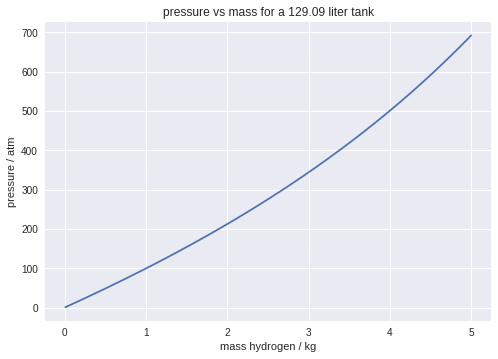

In [11]:
import numpy as np
import matplotlib.pyplot as plt

mass = np.linspace(.01,5,200)

Vmolar = Vtank/(mass*1000/MW)

a = 0.42747*R**2*Tcritical**2/Pcritical
b = 0.08664*R*Tcritical/Pcritical
m = 0.48508 + 1.55171*acentric_factor - 0.1561*acentric_factor**2
Tr = T/Tcritical
alpha = (1 + m*(1-Tr**0.5))**2

Ptank = R*T/(Vmolar - b) - alpha*a/(Vmolar*(Vmolar+b))

plt.plot(mass, Ptank)
plt.xlabel('mass hydrogen / kg')
plt.ylabel('pressure / atm')
plt.title('pressure vs mass for a ' + str(round(Vtank,2)) + ' liter tank');

For an ideal gas at constant temperature, the pressure mass relationship would be a straight line. The nonlinear nature of this solution demonstrates the tank is operating in a regime where hydrogen gas behaves as a nonideal gas.

## Problem 3. Python function to estimate hydrogen mass.

(Note: This problem requires some Python coding skills, including the definition of functions.)

Building on the last problem, write a Python function that returns an estimate the mass of hydrogen in the tank given measurements of pressure, temperature, and the tank volume.

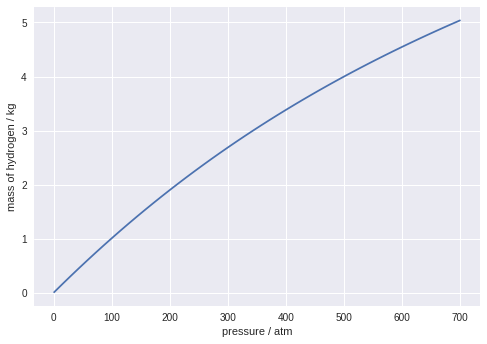

In [15]:
from scipy.optimize import fsolve

def mass_in_tank(P, T=298, Vtank=129.09):
  a = 0.42747*R**2*Tcritical**2/Pcritical
  b = 0.08664*R*Tcritical/Pcritical
  m = 0.48508 + 1.55171*acentric_factor - 0.1561*acentric_factor**2

  Tr = T/Tcritical
  alpha = (1 + m*(1-Tr**0.5))**2
  
  A = alpha*a*P/(R**2*T**2)
  B = b*P/(R*T)
  
  f = lambda z: z**3 - z**2 + (A-B-B**2)*z - A*B
  z = float(fsolve(f,1.0))

  Vmolar = z*R*T/P     # molar volume
  return MW*Vtank/Vmolar/1000


# demonstrate solution

P = np.linspace(1,700)
plt.plot(P, [mass_in_tank(p) for p in P])
plt.xlabel('pressure / atm')
plt.ylabel('mass of hydrogen / kg');

## Problem 4. Limit on tank leak rate.

The lower flammability limit of hydrogen in air is 4 volume%. Assume the vehicle is stored in a single car garage with interior dimensions 7m (H) x 4m (W) x 2.5m (H), and the air is replenished at a rate of 0.03 air changes per hour.  What is the maximum tolerable leakage rate of hydrogen from the car storage tanks? Express the answer as a mass flow. What amount of time would be required for 5kg to safely dissipate by leakage from the tanks. Does this calculation suggestion any engineering challenges?

In [19]:
# volume of the garage

Vgarage = 7*4*2.5*1000   # liters
nflow = 0.03*1*Vgarage/(R*T)

print('total molar flowrate through garage =', nflow, 'gmol/hour')

nH2flow = 0.04*nflow

print('maximum hydrogen molar flowrate through garage =', nH2flow, 'gmol/hour')

mH2flow = MW*nH2flow

print('maximum hydrogen molar flowrate through garage =', mH2flow, 'g/hour')

tfinal = 5000/mH2flow

print('minimum time to safely dissipate 5kg hydrogen =', tfinal, 'hours')
print('minimum time to safely dissipate 5kg hydrogen =', tfinal/24, 'days')


total molar flowrate through garage = 85.87594279517198 gmol/hour
maximum hydrogen molar flowrate through garage = 3.435037711806879 gmol/hour
maximum hydrogen molar flowrate through garage = 6.924623822477252 g/hour
minimum time to safely dissipate 5kg hydrogen = 722.0608841985113 hours
minimum time to safely dissipate 5kg hydrogen = 30.08587017493797 days


The engineering challenge is to design a storage tank that dissipates hydrogen at a rate no greater than about 7g/hr when filled to a pressure of 10,000 psig.  